## LandTrendr Implementation For Decadal Averaging of Spectral Indices

# Requirements: 

Python:

* geemap
* ee
* matplotlib
* numpy
* pandas
* oeel ** 

Other:
* Google Earth Engine Account

The LandTrendr algorithm is highly efficient and extensive tool with documentation at this link: https://emapr.github.io/LT-GEE/

This version uses the latest processing efforts of the Landsat TM+ ETM+ and OLI collection 2

** this package allows the user to run GEE modules directly without the pitfalls of translating JS to Python.

In [2]:
%config IPCompleter.use_jedi = False

import ee
import geemap
from ipygee import chart as chart
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr

 # GEE Authentication
 
 - The ee.authenticate line is necessary the first time using ee and requires the user to log into their own Earth Engine account which will allow access to a personal authentication code. 
 - Subsequent useage of this notebook should retain authentication for some time.
 - Comment and un-comment the authenticate command where required
 
 running the cell first following cell below runs the authentication ("ee.Authenticate") process. (time with a registered EE account <30s)
 
 ### Paste the Authetication code into the box below. 
 
 (press enter to save token, comment out this box until prompted again )
 
 Done correctly the authentication will last some time, and can be commented until the "ee_intialize" cell fails, then the authentication token must be refreshed

In [3]:
#ee.Authenticate()

In [3]:
geemap.ee_initialize()

### Load the EE package

The landTrendr package is developed to construct timeseries of landsat imagery for the purpose of land cover detection. The base parameters are optimised for deforestation event detection. 

This utilisation of the GEE asset (with apache license i.e. free for use) allows for the latest version of LandTrendr to be used. In contrast to early versions this allows for the utilisation of the Landsat Collection 2 reprocessing effort with improvements in cloud masking capabilities. Primarily we use "ltgee.buildSRcollection"

In [4]:
oeel = geemap.requireJS()

Map = geemap.Map()

github_url = 'https://github.com/eMapR/LT-GEE/blob/master/LandTrendr.js'

ltgee = geemap.requireJS(github_url)

ltgee.availability   # This command lists all the functions within the LandTrenr Module

#ltgee.version   # This command accesses the version function (prints the version of the LandTrendr module

IMPORTANT! Please be advised:
- This version of the LandTrendr.js modules
  uses Landsat Collection 2 data
- This version (0.2.0) does NOT use the Roy et al. coefficients


{'version': 'string',
 'buildSensorYearCollection': 'function',
 'getSRcollection': 'function',
 'getCombinedSRcollection': 'function',
 'buildSRcollection': 'function',
 'getCollectionIDlist': 'function',
 'countClearViewPixels': 'function',
 'buildClearPixelCountCollection': 'function',
 'removeImages': 'function',
 'getLTvertStack': 'function',
 'calcIndex': 'function',
 'TScollectionToStack': 'function',
 'buildLTcollection': 'function',
 'transformSRcollection': 'function',
 'runLT': 'function',
 'getFittedData': 'function',
 'makeRGBcomposite': 'function',
 'mapRGBcomposite': 'function',
 'collectionToBandStack': 'function',
 'timesyncLegacyStack': 'function',
 'getSegmentCount': 'function',
 'getSegmentDictionary': 'function',
 'getSegmentArray': 'function',
 'getPixelInfo': 'function',
 'ltPixelTimeSeries': 'function',
 'ltPixelTimeSeriesArray': 'function',
 'getSegmentData': 'function',
 'getYearBandNames': 'function',
 'indexFlipper': 'function',
 'makeBoolean': 'function',
 

## Initiate With a Shapefile

This notebook assumes the user has a shapefile saved as an asset on GEE

In [5]:
dataset = 'Meuse_Catchment_4326'
crs = 'EPSG:4326'
fignum = 0
RGB_VIS = {'bands':['B3','B2','B1'], 'min':0, 'max':1.5e3}

In [6]:
startYear = 1984 #TODO - user input

endYear = 2022 #TODO - user input

startDay = '06-20' #TODO - user input

endDay = '08-31' #TODO - user input

#index = 'NDVI'
# maskOptions = ['cloud', 'shadow', 'snow', 'water', 'waterplus','nonforest']

maskThese = ['cloud', 'shadow', 'snow', 'water'] #TODO - user input?

runParams = { 
    "maxSegments": 6,
    "spikeThreshold": 0.9,
    "vertexCountOvershoot": 3,
    "preventOneYearRecovery": True,
    "recoveryThreshold": 0.25,
    "pvalThreshold": 0.05,
    "bestModelProportion": 0.75,
    "minObservationsNeeded": 6
}

list_of_indices = ['NDVI', 'EVI', 'NBR', 'NDMI', 'GNDVI', 'NDBI'] 

ftv_list = [
    'NDVI', # normalized diff vegetation index
    'NDFI',
    'NDMI',
    'EVI', # enhanced vegetation info
    'TCB',
    'TCW',
    'TCG',
    'TCA',
    'B1',
    'B2',
    'B3',
    'B4', # LS band 4, red
    'B5', # LS band 5, near-infrared
    'B7'
]


## The Table Data

- Here the table, a vector of catchments, is loaded from the users' assets in earth engine 

#TODO rewrite to a local .shp

- The area is calculated of each shape and ranked per area, assuming that the largest is the most computationally expensive
- This is done so that we can iterate from smallest to largest, or the opposite, should any memory issues become apparent.

In [7]:
table = ee.FeatureCollection(f"projects/mohanrahan/assets/{dataset}")

def set_area_m2(feature):
    area = feature.geometry().area()
    setting = feature.set('area_m2', area)
    return setting

def set_id(feature):
    getting = ee.String(feature.get('system:index'))
    setting = feature.set('system_index', getting)
    return setting
    


table_area = table.map(set_area_m2).map(set_id)

Filtered_Sorted = table_area.filter(ee.Filter.gt('area_m2', 0)).sort('area_m2', True)  # true ranks from smallest to largest

area_reduced = Filtered_Sorted.reduceToImage(['area_m2'],'mean')

geom = Filtered_Sorted.first().geometry()

sys_index = Filtered_Sorted.aggregate_array('system:index').getInfo()

ind = sys_index[0]

feature = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))

filtered_table = feature.getInfo()

aoi = feature.geometry()

print(f'-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): {len(sys_index)} indices -- \n \n{sys_index}\n')
print(f'-- first_index: -- \n \n{ind}\n')
print(f'-- filtered_table: -- \n \n{filtered_table["columns"]}\n')

-- sys_indices (sorted by column: area_m2 > 50e6 , H-->L): 44 indices -- 
 
['00000000000000000000', '00000000000000000001', '00000000000000000006', '0000000000000000000b', '0000000000000000000e', '0000000000000000001f', '00000000000000000021', '00000000000000000022', '00000000000000000007', '0000000000000000001c', '00000000000000000009', '0000000000000000000c', '0000000000000000001b', '0000000000000000001d', '0000000000000000000d', '00000000000000000018', '00000000000000000024', '00000000000000000008', '00000000000000000013', '00000000000000000017', '0000000000000000001e', '00000000000000000002', '00000000000000000010', '00000000000000000026', '0000000000000000001a', '0000000000000000002b', '00000000000000000016', '0000000000000000002a', '00000000000000000023', '00000000000000000029', '00000000000000000015', '00000000000000000003', '00000000000000000011', '00000000000000000019', '0000000000000000000f', '00000000000000000025', '0000000000000000000a', '00000000000000000014', '0000000000

In [12]:
gdf = geemap.ee_to_pandas(Filtered_Sorted)

gdf.to_excel(f'meuse/{dataset}_table.xlsx')

In [13]:
table_area.first().get('system:index').getInfo()

'00000000000000000000'

In [14]:
Map.addLayer(Filtered_Sorted, {}, 'table')
Map.centerObject(Filtered_Sorted, 10)

Map

Map(bottom=11452.0, center=[50.15796357001099, 5.4429589044812055], controls=(WidgetControl(options=['position…

In [15]:
def clip_collection(image: ee.Image)-> ee.Image:
    
    """
    reduce the size of the image colelction to be only pixels relevant to the aoi
    """
    return image.clip(aoi).copyProperties(image)

def image_band_mean(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.mean(),
    'region': aoi,
    'scale': scale,
    'band': 'B1_mean',
    })
    
    return chart_ts_region.dataframe

def image_band_median(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.median(),
    'region': aoi,
    'scale': scale,
    'band': 'B1_median',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_5(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([5]),
    'region': aoi,
    'scale': scale,
    'band': 'B1_p5',
    })
    
    return chart_ts_region.dataframe

def image_band_percentile_95(imageCollection, scale):
    
    chart_ts_region = chart.Image.series(**{
    'imageCollection': imageCollection,
    'reducer': ee.Reducer.percentile([95]),
    'region': aoi,
    'scale': scale,
    'band': 'B1_p95',
    })
    
    return chart_ts_region.dataframe



def ND_to_bands(image):
    
    ndvi = image.normalizedDifference(['B4','B3']).rename('ndvi') # NDVI is normalized difference between NIR band4 and red band3

    evi = image.expression('2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')}).rename('evi')

    nbr = image.normalizedDifference(['B4','B7']).rename('nbr') #NBR is NIR band 4 and SWIR2 band 7

    ndmi = image.normalizedDifference(['B4','B5']).rename('ndmi') #NDMI is NIR band 4 and SWIR1 band 5

    gndvi = image.normalizedDifference(['B4','B2']).rename('gndvi') #GNDVI is NIR band 4 and green band 2

    ndbi = image.normalizedDifference(['B5','B4']).rename('ndbi') #NDBI is SWIR1 B5 and NIR B4

    
    return image.addBands([ndvi, evi, nbr, ndmi, gndvi, ndbi])


In [16]:
def tcTrans(image):
    # Calculate tasseled cap transformation
    brightness = image.expression(
        '(L1 * B1) + (L2 * B2) + (L3 * B3) + (L4 * B4) + (L5 * B5) + (L6 * B6)',
        {
            'L1': image.select('B1'),
            'B1': 0.2043,
            'L2': image.select('B2'),
            'B2': 0.4158,
            'L3': image.select('B3'),
            'B3': 0.5524,
            'L4': image.select('B4'),
            'B4': 0.5741,
            'L5': image.select('B5'),
            'B5': 0.3124,
            'L6': image.select('B7'),
            'B6': 0.2303
        })
    greenness = image.expression(
        '(L1 * B1) + (L2 * B2) + (L3 * B3) + (L4 * B4) + (L5 * B5) + (L6 * B6)',
        {
            'L1': image.select('B1'),
            'B1': -0.1603,
            'L2': image.select('B2'),
            'B2': -0.2819,
            'L3': image.select('B3'),
            'B3': -0.4934,
            'L4': image.select('B4'),
            'B4': 0.7940,
            'L5': image.select('B5'),
            'B5': -0.0002,
            'L6': image.select('B7'),
            'B6': -0.1446
        })
    wetness = image.expression(
        '(L1 * B1) + (L2 * B2) + (L3 * B3) + (L4 * B4) + (L5 * B5) + (L6 * B6)',
        {
            'L1': image.select('B1'),
            'B1': 0.0315,
            'L2': image.select('B2'),
            'B2': 0.2021,
            'L3': image.select('B3'),
            'B3': 0.3102,
            'L4': image.select('B4'),
            'B4': 0.1594,
            'L5': image.select('B5'),
            'B5': -0.6806,
            'L6': image.select('B7'),
            'B6': -0.6109
        })

    bright = ee.Image(brightness).rename('BRIGHTNESS')
    green = ee.Image(greenness).rename('GREENNESS')
    wet = ee.Image(wetness).rename('WETNESS')

    tasseledCap = ee.Image([bright, green, wet]).copyProperties(image, ['system:time_start'])
    return tasseledCap


## Running LandTrendr over the Shapefile

1. The geometries are called by their system indices updating the 'aoi'
2. The image collection is generated per shapefile and then returns the decadal mean of each index

# TODO:

- The values calculated are the decadal mean of the seasonal medoid
- Can we get an idea of variance in the bands 

In [19]:
imcol = 0

scale = 1000 # define the pixel size for reducing, in meters, initially high to reduce comp time

sys_index = ['00000000000000000027']

for ind in sys_index:
    
    geom_name = ind[16:]
    
    dataset_name = dataset[0:5]
    
    print(f'{dataset_name} catchment, index: {ind}')
    
    aoi = Filtered_Sorted.filter(ee.Filter.eq('system:index', ind))

    """
    the landsat surface reflectance collection builds a combined landsat collection, harmonized, clipped and reduced to medoid
    """
    
    imcol = ltgee.buildSRcollection(startYear, endYear, startDay, endDay, aoi, maskThese).map(clip_collection)
    
    ND_col = imcol.map(ND_to_bands)
    
    TC_col = imcol.map(tcTrans)
    
    df_mean_ND = image_band_mean(ND_col, scale)
    
    df_mean_TC = image_band_mean(TC_col, scale)
    
    df_pct5_ND = image_band_percentile_5(ND_col, scale)
    
    df_pct95_ND = image_band_percentile_95(ND_col, scale)
    
    df_pct5_TC = image_band_percentile_5(TC_col, scale)
    
    df_pct95_TC = image_band_percentile_95(TC_col, scale)
    
    df_mean_ND.reset_index()
    
    df_mean_TC.reset_index()
    
    df_pct5_ND.reset_index()
    
    df_pct95_ND.reset_index()
    
    df_pct5_TC.reset_index()
    
    df_pct95_TC.reset_index()

    joined_means= df_mean_ND.join(df_mean_TC, how='inner')
    
    joined_percentiles_ND = df_pct5_ND.join(df_pct95_ND, how='inner', lsuffix='p5', rsuffix='p95')
    
    joined_percentiles_TC = df_pct5_TC.join(df_pct95_TC, how='inner', lsuffix='p5', rsuffix='p95')
    
    annual = joined_means.join(joined_percentiles_ND, how='inner').join(joined_percentiles_TC, how= 'inner')

    annual.to_excel(f'{dataset_name}/{ind}_annual.xlsx')
    
    print(f'index: {ind} done')
    


Meuse catchment, index: 00000000000000000027
index: 00000000000000000027 done


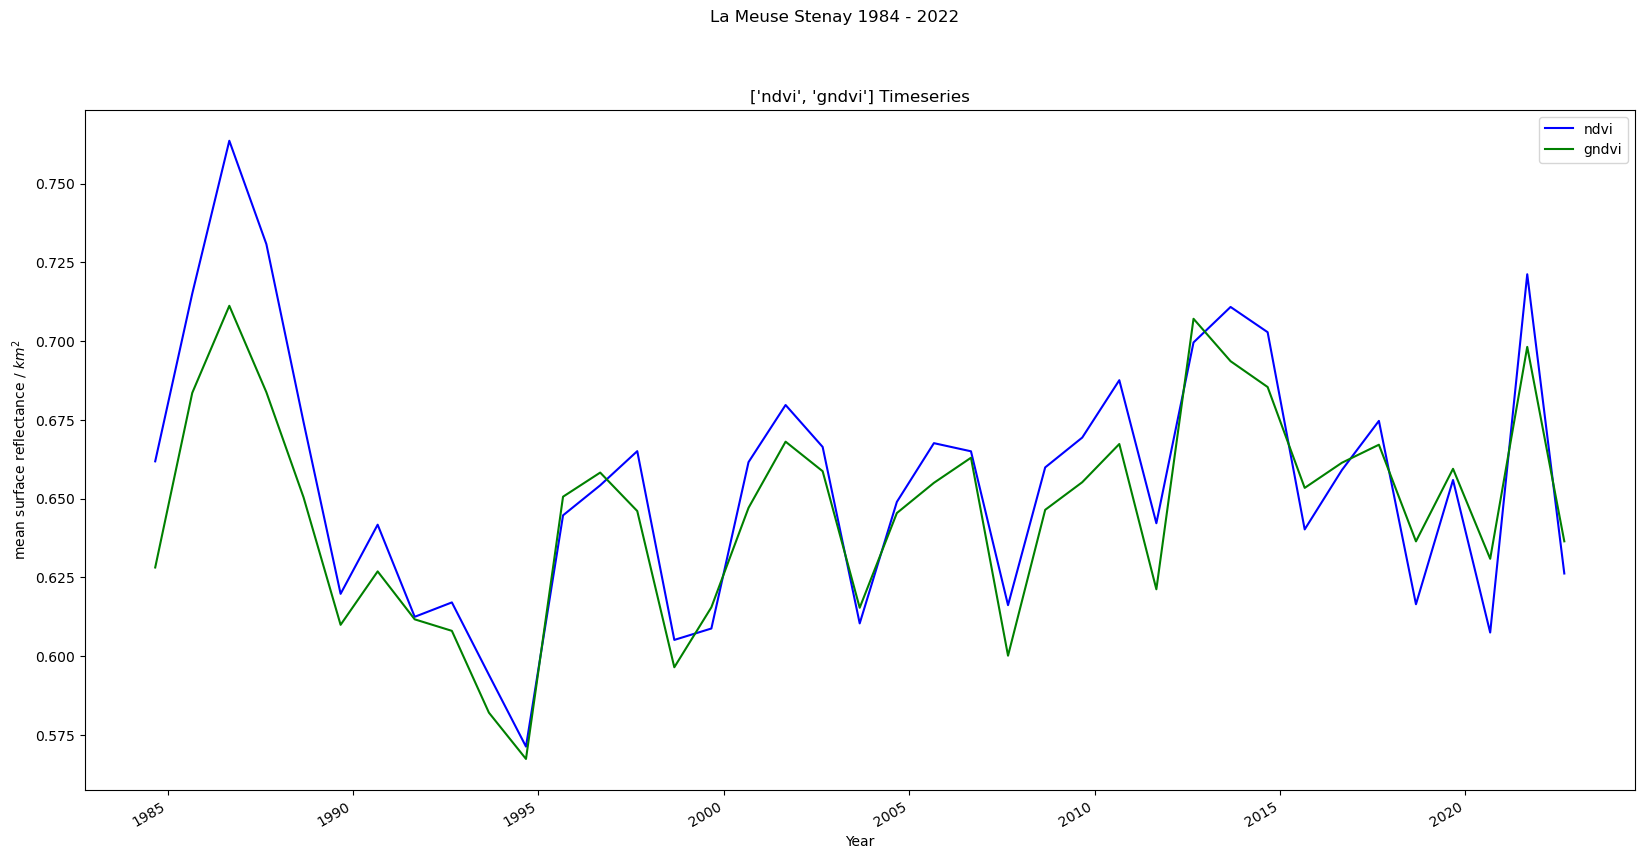

In [125]:
def plot_band_timeseries(annual_df ,  bands=[], percentile=False, decadal= True, separate=False):
    fignum = 0
    for i in bands:
        if separate == True:
            fignum+=1
        plt.figure(fignum)
        df = annual_df.loc[:,i]
        #display(df)
        
        plt.title(f'{bands} Timeseries')
        
        c = 'blue'
        fill  = 'grey'
        
        
        
        if i == 'B1':
            c = 'blue'
            fill  = c
        
        if i == 'B2':
            c = 'green'
            fill  = c
        
        if i == 'B3':
            c = 'red'
            fill=c
            
        if i == 'gndvi':
            c = 'green'
            fill  = c
        
        df.plot(figsize=(20, 10), color=c)
        
        if decadal == True:
            
            decadal_mean = df.rolling(10).mean()
            decadal_mean.plot(c='red', linestyle='dashed', label=f'Decadal Mean {i}')
            plt.axvline(annual_df.index[0], linestyle='dotted')
            plt.scatter(annual_df.index[9], decadal_mean[9], label=f'{i} mean 1984-1993')
            plt.axvline(annual_df.index[9], linestyle='dotted')
            plt.scatter(annual_df.index[19], decadal_mean[19], label=f'{i} mean 1994-2003')
            plt.axvline(annual_df.index[19], linestyle='dotted')
            plt.scatter(annual_df.index[29], decadal_mean[29], label=f'{i} mean 2004-2013')
            plt.axvline(annual_df.index[29], linestyle='dotted')
        
        if percentile == True:
            df_5 = annual_df.loc[:,f'{i}p5']
            df_95 = annual_df.loc[:,f'{i}p95']
            
            df_5.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.05')
            df_95.plot(color='black', linestyle='dashed', alpha=0.7, label=f'{i} p0.95')
            plt.fill_between(annual_df.index, df_5, df_95, color=fill, alpha=0.2)
            plt.title(f'{bands} Timeseries With Decadal Mean and Percentile Bands')
        

        # Add axis labels and a legend
        plt.xlabel('Year')
        
        plt.ylabel(f'mean surface reflectance / $km^2$')
        
        plt.suptitle('La Meuse Stenay 1984 - 2022')
        
        

        #plt.ylim(df.min() - (df.min()*0.7), df.max()*1.2,)
        plt.legend()

plot_band_timeseries(annual, ['ndvi', 'gndvi'], decadal=False)


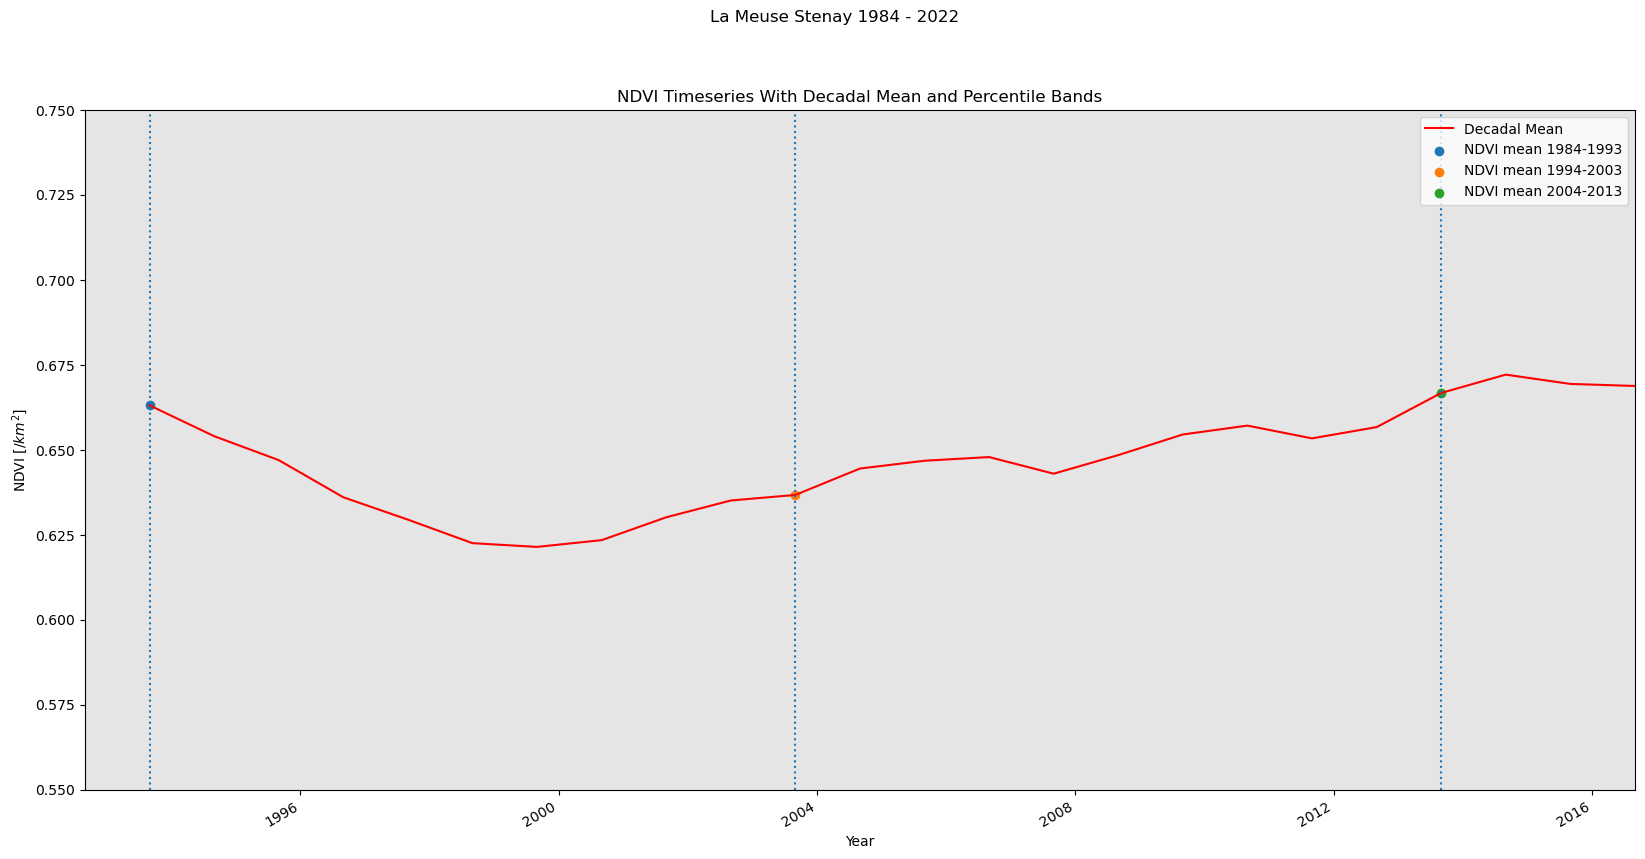

In [82]:
fignum+=1
plt.figure(fignum)
#annual.ndvi.plot(figsize=(20, 10), c='blue')
decadal_mean = annual.ndvi.rolling(10).mean()
decadal_mean.plot(figsize=(20, 10), c='red', label='Decadal Mean')
#annual.ndvip5.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.05')
#annual.ndvip95.plot(color='black', linestyle='dashed', alpha=0.7, label='NDVI p0.95')
plt.fill_between(annual.index, annual.ndvip5, annual.ndvip95, color='grey', alpha=0.2)
plt.axvline(annual.index[0], linestyle='dotted')
plt.scatter(annual.index[9], decadal_mean[9], label='NDVI mean 1984-1993')
plt.axvline(annual.index[9], linestyle='dotted')
plt.scatter(annual.index[19], decadal_mean[19], label='NDVI mean 1994-2003')
plt.axvline(annual.index[19], linestyle='dotted')
plt.scatter(annual.index[29], decadal_mean[29], label='NDVI mean 2004-2013')
plt.axvline(annual.index[29], linestyle='dotted')

# Add axis labels and a legend
plt.xlabel('Year')
plt.ylabel('NDVI [$/km^2$]')

plt.suptitle('La Meuse Stenay 1984 - 2022')
plt.title('NDVI Timeseries With Decadal Mean and Percentile Bands')

plt.ylim(0.55,0.75)
plt.xlim(annual.index[8], annual.index[32])
plt.legend()


In [92]:
annual

,B1,B2,B3,B4,B5,B7,ndvi,evi,nbr,ndmi,...,nbrp95,ndmip95,gndvip95,ndbip95,BRIGHTNESSp5,GREENNESSp5,WETNESSp5,BRIGHTNESSp95,GREENNESSp95,WETNESSp95
1984-08-31 22:00:00,586.192772,907.121631,813.030977,3966.560050,1998.732958,1028.455099,0.661850,-0.255952,0.592217,0.333777,...,0.712713,0.439452,0.740359,-0.158376,3277.313571,1430.436767,-1544.942541,4785.161320,2889.354872,-425.218860
1985-08-31 22:00:00,373.638585,681.981002,606.231943,3650.012682,1931.013696,905.490308,0.715115,-0.226332,0.604158,0.309695,...,0.732445,0.411802,0.810309,-0.161465,2804.830517,1369.387054,-1448.696433,4273.059528,2920.693274,-521.738466
1986-08-31 22:00:00,363.141078,678.738150,542.910321,4014.837741,1876.261006,893.988270,0.763629,-0.254421,0.638943,0.366414,...,0.743950,0.474364,0.822133,-0.213321,2849.474338,1768.247733,-1456.962000,4446.700127,3158.721968,-400.709889
1987-08-31 22:00:00,390.370456,708.230508,592.046947,3739.424006,1882.311264,891.489672,0.730804,-0.243472,0.619759,0.333950,...,0.728340,0.427567,0.790772,-0.200862,2739.962248,1594.580718,-1400.196659,4366.753818,2775.207414,-455.184143
1988-08-31 22:00:00,421.269579,734.139464,680.293332,3496.918467,2039.392370,1026.020626,0.674326,-0.196585,0.549908,0.265093,...,0.724514,0.407757,0.790967,-0.025588,2771.450329,888.139941,-1829.279614,4399.761157,2791.574057,-536.006971
1989-08-31 22:00:00,511.485864,816.527360,801.369931,3385.243357,2170.949359,1175.071624,0.619779,-0.168797,0.493116,0.224037,...,0.728688,0.412188,0.806227,0.017326,2854.711262,757.329150,-2125.708833,4643.260725,2776.162311,-498.831681
1990-08-31 22:00:00,504.809105,809.640500,784.174880,3506.777868,2077.031433,1059.968997,0.641736,-0.203500,0.544076,0.262052,...,0.716971,0.400364,0.771440,-0.068731,2865.568911,1064.043461,-1849.138906,4722.853009,2647.021405,-536.169895
1991-08-31 22:00:00,493.603845,797.927528,808.858844,3309.631839,2171.659410,1191.253449,0.612486,-0.161715,0.481560,0.215182,...,0.724587,0.404181,0.787252,0.024881,2736.504463,742.258880,-2184.320050,4719.838558,2600.062168,-537.696485
1992-08-31 22:00:00,516.978897,829.158032,814.587754,3402.643965,2175.378088,1146.446850,0.617057,-0.174422,0.505298,0.226078,...,0.716758,0.388585,0.768062,0.025440,2925.797057,821.118308,-2153.061985,4656.153426,2601.275134,-519.985589
1993-08-31 22:00:00,634.216905,914.777290,888.374657,3428.521695,2111.171853,1162.074576,0.594058,-0.198605,0.501690,0.243229,...,0.724504,0.416282,0.778941,-0.017942,2575.834775,729.961538,-1942.711850,5171.111020,2845.669333,-439.825267


## Trend analysis per band

- can we look at median band collection and percentile bounds, reduced to a per kilometer scale

In [53]:
stats_LS = geemap.image_stats(LS, aoi, scale=scale)
LS_col_stats = stats_LS.getInfo()
print(LS_col_stats)

The input object must be an ee.Image


AttributeError: 'NoneType' object has no attribute 'getInfo'

***
<a id="Land_Cover"></a>
## Land Cover 

[Linking Reference to Land Cover](#Land_cover)

In [10]:
Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.addLayer(aoi, {}, 'ROI')
Map.centerObject(aoi, 12)
Map

NameError: name 'aoi' is not defined

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…